In [1]:
from PIL import Image
from pathlib import Path
import os
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision.transforms as transforms
import cv2
import pickle
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import skew, kurtosis,variation, gmean, relfreq
import csv
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, mean_squared_error

In [2]:
PATH = "/home/dona/bm75/Project_Chathurika/Classification/data/data/"
path_to_save = "/home/dona/bm75/Project_Chathurika/Classification/data/data/remove_background/"
path_for_models = "/home/dona/bm75/Project_Chathurika/Classification/data/data/models/"
torch.manual_seed(0)

In [3]:
required_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((972, 1296)),
    transforms.ToTensor(),
])

In [4]:
# processing dataset metadata
def process_dataset_meta_info():
    true_files = []
    true_file_paths = os.listdir(PATH + 'WFT/')
    true_file_paths.sort()
    for item in true_file_paths:
        if item[-4:] == ".jpg":
            true_files.append(PATH + 'WFT/' + item)

    negative_files = []
    negative_file_paths = os.listdir(PATH + 'NOTWFT/')
    negative_file_paths.sort()
    for item in negative_file_paths:
        if item[-4:] == ".jpg":
            negative_files.append(PATH + 'NOTWFT/' + item)

    return true_files, negative_files

true_files, negative_files = process_dataset_meta_info()

In [6]:
# Thrip dataset
class ThripDataset(Dataset):
    def __init__(self, file_paths, transform = None):
        self.file_paths = file_paths
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx] # extract the filepath
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            image = self.transform(image)
        
        return image

In [7]:
wft_dataset = ThripDataset(true_files, required_transforms)
wft_data_loader = DataLoader(wft_dataset, 
                          batch_size  = 1, 
                          shuffle     = False, 
                          num_workers = 1)

non_wft_dataset = ThripDataset(negative_files, required_transforms)
non_wft_data_loader = DataLoader(non_wft_dataset, 
                          batch_size  = 1, 
                          shuffle     = False, 
                          num_workers = 1)

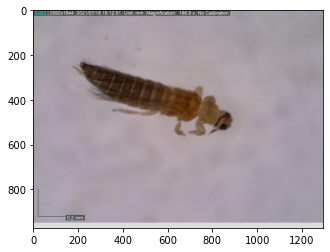

In [9]:
#Display a Image in the dataset
for idx, data in enumerate(non_wft_data_loader):
    data = data.detach().cpu().numpy()
    im = np.moveaxis(data[0], 0, -1)
    plt.imshow(im)
    break

In [10]:
def value_mapping(left, right, is_greater_than):
    if left == right:
        left = 0
        right = 1
    elif is_greater_than:
        if left > right:
            left = 1
            right = 0
        else:
            left = 0
            right = 1
    else:
        if left > right:
            left = 0
            right = 1
        else:
            left = 1
            right = 0
    return left, right 

In [11]:
def number_of_pixels(pixels_arr, fraction = 0.15, offset = 5):
    total_pixel_left = 0
    total_pixel_right = 0
    
    part_length = round(len(pixels_arr)*fraction)
    
    for i in pixels_arr[offset: part_length]:
        total_pixel_left = total_pixel_left + i
        
    for i in pixels_arr[-part_length: -offset]:
        total_pixel_right = total_pixel_right + i
    
    return total_pixel_left, total_pixel_right

In [12]:
def cal_mse(pixels_arr, fraction = 0.33, offset= 5):
    x_axies = list(range(0, len(pixels_arr)))
    x = np.array([x_axies]).reshape((-1,1))
    y = np.array([pixels_arr]).reshape((-1,1))
    part = round(len(x_axies)*fraction)
    x_left = x[offset:part]
    y_left = y[offset:part]
    x_right = x[-part:-offset]
    y_right = y[-part:-offset]

    #cal polynomial regressiion
    x_p_left = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x_left)
    x_p_right = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x_right)
    
    poly_model_left = LinearRegression().fit(x_p_left, y_left)
    poly_model_right = LinearRegression().fit(x_p_right, y_right)
            
    #calculate MSE
    y_predic_left = poly_model_left.predict(x_p_left)
    mse_left = mean_squared_error(y_left,y_predic_left)
            
    y_predic_right = poly_model_right.predict(x_p_right)
    mse_right = mean_squared_error(y_right,y_predic_right)
    
    return mse_left, mse_right

In [13]:
def subimage(image, width, height, box):
    # print(box)
    width = int(width)
    height = int(height)

    src_pts = box.astype("float32")
    # coordinate of the points in box points after the rectangle has been
    # straightened
    dst_pts = np.array([[0, height-1],
                        [0, 0],
                        [width-1, 0],
                        [width-1, height-1]], dtype="float32")

    # the perspective transformation matrix
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)

    # directly warp the rotated rectangle to get the straightened rectangle
    warped = cv2.warpPerspective(image, M, (width, height))
    return warped

In [5]:
def read_direction_labels(file_path):
    with open(file_path) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        wft_direction_label = []
        not_wft_direction_labels = []
        
        for row in csv_reader:
            category = row[2].split('_')
            
            if category[0] == 'WFT':
                wft_direction_label.append(row[1])
            elif category[0] == 'NOTWFT':
                not_wft_direction_labels.append(row[1])
                
    print(len(wft_direction_label))
    print(len(not_wft_direction_labels))
    return wft_direction_label, not_wft_direction_labels

In [6]:
def write_direction_details(file, details):
    formatted_details = []
    header = ['filename', 'category', 'side(left/right)', 'mse', 'ttl_pixels', 'direction_label']
    for item in details:
        row1 = [item['filename'], item['category'], 'left', item['left']['mse'], item['left']['ttl_pixels'], item['left']['label']]
        row2 = [item['filename'], item['category'], 'right', item['right']['mse'], item['right']['ttl_pixels'], item['right']['label']]
        formatted_details.append(row1)
        formatted_details.append(row2)
    
    with open(file, 'w', encoding='UTF8', newline='') as f:
        writer = csv.writer(f)
        # write the header
        writer.writerow(header)
        # write multiple rows
        writer.writerows(formatted_details)

In [7]:
def prepare_data_for_direction_classifier(file_path):
    with open(file_path) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        x_values = []
        y_values = []
        header = True
        for i, row in enumerate(csv_reader):
            if header:
                header = False
                continue
            
            if i%2 == 0:
                continue
                
            x = [float(row[3]), float(row[4])] 
            y = int(row[5])
            x_values.append(x)
            y_values.append(y)
    return x_values, y_values 

In [8]:
def compute_metrics(y_pred, y):
    print('accuracy: ', accuracy_score(y, y_pred))
    p, r, f, _ = precision_recall_fscore_support(y, y_pred, average = 'macro')
    print('precision: ', p)
    print('recall: ', r)
    print('fscore: ', f)

In [46]:
#funtion develop to remove background and extract parts from the image

from scipy import ndimage
from scipy.stats import linregress

def feature_extraction(data_loader, path_to_save, thrip_type, direction_label):
    direction_data = []
    count = 0
    for idx, data in enumerate(data_loader):
        data = data.detach().cpu().numpy()
        im = np.moveaxis(data[0], 0, -1)
        
        #plt.imshow(im)
        #plt.show()
        
        one_chanel = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        h,w = one_chanel.shape
        pixels = one_chanel.reshape(-1)
        mean = np.mean(pixels)
        std = np.std(pixels)
        thresh_val = mean - std 
        ret, thresh_img = cv2.threshold(im,thresh_val,1,cv2.THRESH_BINARY_INV)
        kernel = np.ones((5,5),np.uint8)
        dilation = cv2.dilate(thresh_img,kernel,iterations = 3)
        dilation = np.array(dilation[:,:,1], dtype = np.uint8)
        cnts, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
         
        max_cnt_id = -1
        max_area = 0
        max_cnt = []
        for i, c in enumerate(cnts):
            area = cv2.contourArea(c, oriented = False)
            if (max_area < area):
                max_area = area
                max_cnt_id = i
                max_cnt = c

        out_mask = np.zeros_like(im[:,:,0])
        out_mask = cv2.drawContours( out_mask, [max_cnt] ,-1, 1, cv2.FILLED, 1);
        out_mask = out_mask.astype(np.uint8)
        out_mask_3channel = np.moveaxis([out_mask, out_mask, out_mask], 0, -1) 
        
        masked_image = im.copy()
        masked_image[out_mask_3channel==0.0] = 0.0
        
        out=masked_image.copy()
        rect = cv2.minAreaRect(max_cnt)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        out2 = cv2.drawContours(out,[box],0,(0,0,0),5)
        
        if True:
            theta=rect[2]
            if theta > 45:
                theta = 90 - theta
            rotated_copy  = subimage(out, width=rect[1][0], height=rect[1][1], box=box)
            
            if rotated_copy.shape[0] > rotated_copy.shape[1]:
                rotated_copy = rotated_copy.swapaxes(-2,-3)
            
            name = path_to_save + str(idx).zfill(3) + ".png"
            
            #uncomment this line if you want to save the intermidiate results  
            #cv2.imwrite(name, cv2.cvtColor(rotated_copy*255, cv2.COLOR_BGR2RGB)) 
            
            copy_direction = rotated_copy.copy()
            copy_direction = cv2.cvtColor(copy_direction, cv2.COLOR_BGR2GRAY) #uncomment this line
            size_d = copy_direction.shape
            
            pixels_count = []
            pixels_arr = [] #for colour historgram
            upper_bound = mean - std
            for i in range(size_d[1]):
                num_of_pixels = 0
                for j in range(size_d[0]):
                    if upper_bound > copy_direction[j, i] > 0: #remove upper_bound if you don't want to remove pixels in the edges
                        num_of_pixels = num_of_pixels + 1
                        pixels_arr.append(copy_direction[j, i])
                pixels_count.append(num_of_pixels)

            
            left_ttl_pixels, right_ttl_pixels  = number_of_pixels(pixels_count, fraction = 0.3, offset = 1)
            left_ttl_pixels, right_ttl_pixels = value_mapping(left_ttl_pixels, right_ttl_pixels, False)
            
            mse_left, mse_right = cal_mse(pixels_count , fraction = 0.3, offset = 1)
            mse_left, mse_right = value_mapping(mse_left, mse_right, True)
            
            #print(idx) 
                
            if int(direction_label[idx]) == 1: 
                left_label = 1
                right_label = 0
            else:
                left_label = 0
                right_label = 1
            
            features = {'category': thrip_type,
                              'filename' : idx,
                              'left': { 'label': left_label,
                                         'mse'  : mse_left,
                                         'ttl_pixels': left_ttl_pixels
                                       },
                                
                              'right': { 'label': right_label,  
                                         'mse' : mse_right,
                                         'ttl_pixels' : right_ttl_pixels
                                        }
                               }
            
            direction_data.append(features)
        
#         if idx == 20:
#             break
                
    return direction_data


In [9]:
wft_direction_label, not_wft_direction_label = read_direction_labels(PATH + "label_for_direction/direction_labels.csv")

210
215


In [48]:
wft_direction_details = feature_extraction(wft_data_loader, path_to_save + 'WFT/', 'WFT', wft_direction_label)

In [49]:
not_wft_direction_details = feature_extraction(non_wft_data_loader, path_to_save + 'NOTWFT/', 'NOTWFT', not_wft_direction_label)

In [50]:
direction_details = wft_direction_details + not_wft_direction_details
write_direction_details(PATH + 'label_for_direction/direction_details_raw.csv', direction_details)

In [10]:
x_values, y_values = prepare_data_for_direction_classifier(PATH + 'label_for_direction/direction_details.csv')
len(x_values), len(y_values)

(425, 425)

In [42]:
x_train, x_test, y_train, y_test = train_test_split(np.array(x_values), y_values, test_size = 0.2, random_state = 1)
model = DecisionTreeClassifier(max_depth=5)
model.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [43]:
file = path_for_models + 'direction_classifier.sav'
pickle.dump(model, open(file, 'wb'))

In [44]:
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)
print('....results_for_train_set....')
compute_metrics(y_train, y_pred_train)
print('.....results_for_test_set....')
compute_metrics(y_test, y_pred_test)

....results_for_train_set....
accuracy:  0.9764705882352941
precision:  0.9764632584541899
recall:  0.9764632584541899
fscore:  0.9764632584541899
.....results_for_test_set....
accuracy:  0.9764705882352941
precision:  0.9795918367346939
recall:  0.9736842105263157
fscore:  0.9760698198198199
